# Reconstructing even more features with PyGPlates

In this example, we will reconstruct data from the [Paleobiology Database (PBDB)](https://paleobiodb.org/#/).

Import modules

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pygplates
from shapely.geometry.polygon import Polygon, LinearRing, Point
# import scipy
import geopandas as gpd
# import shapely

## Download and import PBDB data

We can import data from the PBDB using the data url straight into [`pandas`](https://pandas.pydata.org/docs/reference/index.html#api). For the following file, it takes about ~8 mins. Alternatively, we can download the csv file from their [website](https://paleobiodb.org/classic/displayDownloadGenerator) and import that.


It is easier if we exclude the metadata at the beginning of the file (an option on the download page), otherwise we need to know how long the header is so that we skip it when we import it.

In [22]:
# download data for the Cenozoic, and inclue the paleoenvironment column.
# You can use the download page to play with the options and get the download link and/or CSV.

pbdb_data_url = 'https://paleobiodb.org/data1.2/occs/list.csv?max_ma=66&min_ma=0&show=coords,env'

In [25]:
%%time

# import from the URL
pbdb_data = pd.read_csv(pbdb_data_url, sep=',')  # Skip the first 17 rows.

KeyboardInterrupt: 

In [28]:
# import from the csv
pbdb_data = pd.read_csv('data/pbdb_data.csv', sep=',')

In [33]:
pbdb_data

,occurrence_no,record_type,reid_no,flags,collection_no,identified_name,identified_rank,identified_no,difference,accepted_name,accepted_rank,accepted_no,early_interval,late_interval,max_ma,min_ma,reference_no,lng,lat,environment
0,4451,occ,NaN,NaN,32050,Brabovus nanincisus,species,374469,NaN,Brabovus nanincisus,species,374469.0,Pliocene,NaN,5.333,2.588,4451,35.130001,-3.130000,eolian indet.
1,14494,occ,NaN,NaN,1282,Nucula spheniopsis,species,61430,recombined as,Nucula (Nucula) sphenopsis,species,61431.0,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore
2,14495,occ,NaN,NaN,1282,Nucula cf. smithvillensis,species,61429,obsolete variant of,Nucula (Nucula) smithvillensis,species,61429.0,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore
3,14496,occ,NaN,NaN,1282,Hilgardia multilineata,species,60655,NaN,Hilgardia multilineata,species,60655.0,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore
4,14497,occ,22165.0,NaN,1282,Calorhadia mater,species,109852,recombined as,Calorhadia (Litorhadia) mater,species,109851.0,Lutetian,Priabonian,47.800,33.900,11845,-90.405556,32.855000,offshore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521623,1592487,occ,NaN,NaN,225171,Colubriformes indet.,unranked clade,455119,NaN,Colubriformes,unranked clade,455119.0,Langhian,NaN,15.970,13.820,81502,8.617388,47.253071,terrestrial indet.
521624,1592497,occ,NaN,NaN,167427,Lamprophiinae indet.,subfamily,455120,NaN,Lamprophiinae,subfamily,455120.0,Late Oligocene,NaN,28.400,23.030,81505,33.200001,-8.933333,fluvial indet.
521625,1592500,occ,NaN,NaN,225174,Calappa n. sp. laraensis,species,223251,NaN,Calappa laraensis,species,223251.0,Late Oligocene,Early Miocene,28.400,15.970,81510,-69.948608,10.583056,marine indet.
521626,1592501,occ,NaN,NaN,131483,Raninoides n. sp. rathbunae,species,222851,NaN,Raninoides rathbunae,species,222851.0,Late Eocene,NaN,37.200,33.900,81510,-69.833336,11.000000,marine indet.


We can easily check the columns of our data

In [34]:
pbdb_data.columns

Index(['occurrence_no', 'record_type', 'reid_no', 'flags', 'collection_no',
       'identified_name', 'identified_rank', 'identified_no', 'difference',
       'accepted_name', 'accepted_rank', 'accepted_no', 'early_interval',
       'late_interval', 'max_ma', 'min_ma', 'reference_no', 'lng', 'lat',
       'environment'],
      dtype='object')

In [37]:
pbdb_data.environment.unique()

array(['eolian indet.', 'offshore', 'interdistributary bay',
       'marine indet.', 'coastal indet.', 'shallow subtidal indet.',
       'open shallow subtidal', 'transition zone/lower shoreface',
       'carbonate indet.', 'deep subtidal ramp', 'offshore ramp', nan,
       'prodelta', 'delta front', 'peritidal',
       'lagoonal/restricted shallow subtidal', 'foreshore',
       'deep subtidal shelf', 'basinal (carbonate)', 'shoreface',
       'estuary/bay', 'offshore indet.', 'deep subtidal indet.',
       'reef, buildup or bioherm', 'paralic indet.', 'lagoonal',
       'terrestrial indet.', '"floodplain"', 'lacustrine - large',
       '"channel"', 'deep-water indet.', 'wet floodplain',
       'crevasse splay', 'pond', 'fine channel fill', 'fluvial indet.',
       'lacustrine - small', 'lacustrine indet.',
       'fluvial-lacustrine indet.', 'karst indet.', 'mire/swamp',
       'sinkhole', 'fissure fill', 'cave', 'basinal (siliciclastic)',
       'alluvial fan', 'offshore shelf', 'del

Based on the environments, we can separate them into broad 'marine' and 'terrestrial' types.
First we create a definition of what the broad environment type is, and then we create a new column with this information

In [39]:
def broad_environment(row):
    if row['environment'] == 'marine indet.'\
    or row['environment'] == 'carbonate indet.'\
    or row['environment'] == 'peritidal'\
    or row['environment'] == 'shallow subtidal indet.'\
    or row['environment'] == 'open shallow subtidal'\
    or row['environment'] == 'lagoonal/restricted shallow subtidal'\
    or row['environment'] == 'sand shoal'\
    or row['environment'] == 'reef'\
    or row['environment'] == 'buildup or bioherm'\
    or row['environment'] == 'perireef or subreef'\
    or row['environment'] == 'intrashelf/intraplatform reef'\
    or row['environment'] == 'platform/shelf-margin reef'\
    or row['environment'] == 'slope/ramp reef'\
    or row['environment'] == 'basin reef'\
    or row['environment'] == 'deep subtidal ramp'\
    or row['environment'] == 'deep subtidal shelf'\
    or row['environment'] == 'deep subtidal indet.'\
    or row['environment'] == 'offshore ramp'\
    or row['environment'] == 'offshore shelf'\
    or row['environment'] == 'offshore indet.'\
    or row['environment'] == 'slope'\
    or row['environment'] == 'basinal (carbonate)'\
    or row['environment'] == 'basinal (siliceous)'\
    or row['environment'] == 'marginal marine indet.'\
    or row['environment'] == 'paralic indet.'\
    or row['environment'] == 'lagoonal'\
    or row['environment'] == 'coastal indet.'\
    or row['environment'] == 'foreshore'\
    or row['environment'] == 'shoreface'\
    or row['environment'] == 'transition zone/lower shoreface'\
    or row['environment'] == 'offshore'\
    or row['environment'] == 'deltaic indet.'\
    or row['environment'] == 'delta plain'\
    or row['environment'] == 'interdistributary bay'\
    or row['environment'] == 'delta front'\
    or row['environment'] == 'prodelta'\
    or row['environment'] == 'deep-water indet.'\
    or row['environment'] == 'submarine fan'\
    or row['environment'] == 'basinal (siliciclastic)'\
    or row['environment'] == 'estuary/bay':
        val = 'marine'
    elif row['environment'] == 'terrestrial indet.'\
    or row['environment'] == 'fluvial-lacustrine indet.'\
    or row['environment'] == 'fluvial indet.'\
    or row['environment'] == 'channel'\
    or row['environment'] == 'channel lag'\
    or row['environment'] == 'coarse channel fill'\
    or row['environment'] == 'fine channel fill'\
    or row['environment'] == 'floodplain'\
    or row['environment'] == 'wet floodplain'\
    or row['environment'] == 'dry floodplain'\
    or row['environment'] == 'levee'\
    or row['environment'] == 'crevasse splay'\
    or row['environment'] == 'lacustrine indet.'\
    or row['environment'] == 'lacustrine - large'\
    or row['environment'] == 'lacustrine - small'\
    or row['environment'] == 'pond'\
    or row['environment'] == 'crater lake'\
    or row['environment'] == 'karst indet.'\
    or row['environment'] == 'fissure fill'\
    or row['environment'] == 'cave'\
    or row['environment'] == 'sinkhole'\
    or row['environment'] == 'eolian indet.'\
    or row['environment'] == 'dune'\
    or row['environment'] == 'interdune'\
    or row['environment'] == 'loess'\
    or row['environment'] == 'fluvial-deltaic indet.'\
    or row['environment'] == 'deltaic indet.'\
    or row['environment'] == 'delta plain'\
    or row['environment'] == 'interdistributary bay'\
    or row['environment'] == 'estuary/bay'\
    or row['environment'] == 'lacustrine deltaic indet.'\
    or row['environment'] == 'lacustrine delta plain'\
    or row['environment'] == 'lacustrine interdistributary bay'\
    or row['environment'] == 'lacustrine delta front'\
    or row['environment'] == 'lacustrine prodelta'\
    or row['environment'] == 'alluvial fan'\
    or row['environment'] == 'mire/swamp'\
    or row['environment'] == 'spring'\
    or row['environment'] == 'tar':
        val = 'terrestrial'
    elif row['environment'] == 'glacial': 
        val = 'glacial'
    elif row['environment'] == np.nan: 
        val = 'not-specified'
    else:
        val = 'skipped'
    return val

In [40]:
pbdb_data['environment_broad'] = pbdb_data.apply(broad_environment, axis=1)

In [41]:
pbdb_data

,occurrence_no,record_type,reid_no,flags,collection_no,identified_name,identified_rank,identified_no,difference,accepted_name,...,accepted_no,early_interval,late_interval,max_ma,min_ma,reference_no,lng,lat,environment,environment_broad
0,4451,occ,NaN,NaN,32050,Brabovus nanincisus,species,374469,NaN,Brabovus nanincisus,...,374469.0,Pliocene,NaN,5.333,2.588,4451,35.130001,-3.130000,eolian indet.,terrestrial
1,14494,occ,NaN,NaN,1282,Nucula spheniopsis,species,61430,recombined as,Nucula (Nucula) sphenopsis,...,61431.0,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore,marine
2,14495,occ,NaN,NaN,1282,Nucula cf. smithvillensis,species,61429,obsolete variant of,Nucula (Nucula) smithvillensis,...,61429.0,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore,marine
3,14496,occ,NaN,NaN,1282,Hilgardia multilineata,species,60655,NaN,Hilgardia multilineata,...,60655.0,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore,marine
4,14497,occ,22165.0,NaN,1282,Calorhadia mater,species,109852,recombined as,Calorhadia (Litorhadia) mater,...,109851.0,Lutetian,Priabonian,47.800,33.900,11845,-90.405556,32.855000,offshore,marine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521623,1592487,occ,NaN,NaN,225171,Colubriformes indet.,unranked clade,455119,NaN,Colubriformes,...,455119.0,Langhian,NaN,15.970,13.820,81502,8.617388,47.253071,terrestrial indet.,terrestrial
521624,1592497,occ,NaN,NaN,167427,Lamprophiinae indet.,subfamily,455120,NaN,Lamprophiinae,...,455120.0,Late Oligocene,NaN,28.400,23.030,81505,33.200001,-8.933333,fluvial indet.,terrestrial
521625,1592500,occ,NaN,NaN,225174,Calappa n. sp. laraensis,species,223251,NaN,Calappa laraensis,...,223251.0,Late Oligocene,Early Miocene,28.400,15.970,81510,-69.948608,10.583056,marine indet.,marine
521626,1592501,occ,NaN,NaN,131483,Raninoides n. sp. rathbunae,species,222851,NaN,Raninoides rathbunae,...,222851.0,Late Eocene,NaN,37.200,33.900,81510,-69.833336,11.000000,marine indet.,marine


In [44]:
type(pbdb_data)

pandas.core.frame.DataFrame

## Reconstruct PBDB data with PyGPlates


### Import files into PyGPlates

In [132]:
# location of files we want to use
rotation_filename = 'Data/Muller2019-Young2019-Cao2020_CombinedRotations.rot'
static_polygon_file = 'Data/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.gpmlz'
coastline_filename = 'Data/Global_EarthByte_GPlates_PresentDay_Coastlines.gpmlz'

# read into pygplates
rotation_model = pygplates.RotationModel(rotation_filename)
static_polygons = pygplates.FeatureCollection(static_polygon_file)
coastlines = pygplates.FeatureCollection(coastline_filename)

To reconstruct out PBDB data, which is currently a `pandas` dataframe, we need to convert it into a `pygplates.Feature`. We can also preserve our favourite columns using [`set_shapefile_attribute`](https://www.gplates.org/docs/pygplates/generated/pygplates.feature#pygplates.Feature.set_shapefile_attribute)

In [45]:
pbdb_data.columns

Index(['occurrence_no', 'record_type', 'reid_no', 'flags', 'collection_no',
       'identified_name', 'identified_rank', 'identified_no', 'difference',
       'accepted_name', 'accepted_rank', 'accepted_no', 'early_interval',
       'late_interval', 'max_ma', 'min_ma', 'reference_no', 'lng', 'lat',
       'environment', 'environment_broad'],
      dtype='object')

In [49]:
# convert pbdb data to gplates feature
pbdb_point_features = []

for index, row in pbdb_data.iterrows():
    point = pygplates.PointOnSphere(float(row.lat), float(row.lng))  # use the lat and lng columns as our coordinates
    pbdb_point_feature = pygplates.Feature()
    pbdb_point_feature.set_geometry(point)
    pbdb_point_feature.set_shapefile_attribute('environment', row.environment)
    pbdb_point_feature.set_shapefile_attribute('environment_broad', row.environment_broad)
    pbdb_point_feature.set_shapefile_attribute('early_interval', row.early_interval)
    pbdb_point_feature.set_shapefile_attribute('late_interval', row.late_interval)
    pbdb_point_feature.set_shapefile_attribute('occurrence_no', row.occurrence_no)
    pbdb_point_feature.set_valid_time(row.max_ma, row.min_ma)  # assign ages for each point
    pbdb_point_features.append(pbdb_point_feature)   # save to pbdb_point_features


In [52]:
# Assign plate IDs to the fossil data so that each point now has a plate ID

pbdb_cc = pygplates.partition_into_plates(static_polygons, rotation_model, 
                                          pbdb_point_features,
                                          properties_to_copy = [pygplates.PartitionProperty.reconstruction_plate_id])


### Reconstruct points to 30 Ma

Similar to previous examples, we use `pygplates.reconstruct`

In [53]:
# reconstruct pbdb data
pbdb_30Ma = []
reconstruction_time = 30
pygplates.reconstruct(pbdb_cc, rotation_model, pbdb_30Ma, reconstruction_time)

### Convert our reconstructed points into a geoDataFrame

Using a GeoDataFrame makes it easier to keep track of all our attributes!

In [84]:
def create_geodataframe_from_pbdb(pygplates_recon_geom, reconstruction_time):
    """ This is a function to convert reconstructed paleobiology database point features
    from pygplates into a GeoDataFrame. Note that here, the input geometry must be a point
    
    Input: 
        - pygplates.ReconstructedFeatureGeometry (i.e., output of pygplates.reconstruct)
        - recontruction time - this is just for safekeeping in the geodataframe!
    Output: 
        - gpd.GeoDataFrame of the feature"""
    
    # create new and empy geodataframe
    recon_gpd = gpd.GeoDataFrame()
    recon_gpd['NAME'] = None
    recon_gpd['PLATEID1'] = None
    recon_gpd['FROMAGE'] = None
    recon_gpd['TOAGE'] = None
    recon_gpd['environment'] = None
    recon_gpd['environment_broad'] = None
    recon_gpd['late_interval'] = None
    recon_gpd['early_inverval'] = None
    recon_gpd['occurrence_no'] = None
    recon_gpd['geometry'] = None
    recon_gpd['reconstruction_time'] = None
    recon_gpd = recon_gpd.set_crs(epsg=4326)
    
    # empty arrays to append to
    fromages             = []
    toages               = []
    plateid1s            = []
    environments         = []
    broad_environments   = []
    early_intervals      = []
    late_intervals       = []
    occurence_nos        = []
    geometries           = []
    reconstruction_times = []
    
    for i in pygplates_recon_geom:
        point = i.get_feature()
        # contains present-day coordinates
        plat, plon = point.get_geometry().to_lat_lon()
        
        # reconstructed coordinates
        recon_point = i.get_reconstructed_geometry()
        rlat, rlon = recon_point.to_lat_lon()
        
        # get feature attributes
        fromages.append(point.get_valid_time()[0])
        toages.append(point.get_valid_time()[1])
        plateid1s.append(point.get_reconstruction_plate_id())
        
        # get other attributes
        environments.append(point.get_shapefile_attribute('environment'))
        broad_environments.append(point.get_shapefile_attribute('environment_broad'))
        early_intervals.append(point.get_shapefile_attribute('early_interval'))
        late_intervals.append(point.get_shapefile_attribute('late_interval'))
        occurence_nos.append(point.get_shapefile_attribute('occurrence_no'))

        reconstruction_times.append(reconstruction_time) 
        
        # convert point into shapely geometry
        geometry = Point(rlon, rlat)
        geometries.append(geometry)
 

    # write to geodataframe
    recon_gpd['PLATEID1'] = plateid1s
    recon_gpd['FROMAGE'] = fromages
    recon_gpd['TOAGE'] = toages
    recon_gpd['environment'] = environments
    recon_gpd['environment_broad'] = broad_environments
    recon_gpd['late_interval'] = late_intervals
    recon_gpd['early_inverval'] = early_intervals
    recon_gpd['occurrence_no'] = occurence_nos
    recon_gpd['geometry'] = geometries
    recon_gpd['reconstruction_time'] = reconstruction_times
    
    return recon_gpd

In [110]:
gpd_pbdb = create_geodataframe_from_pbdb(pbdb_30Ma, reconstruction_time)

<AxesSubplot:>

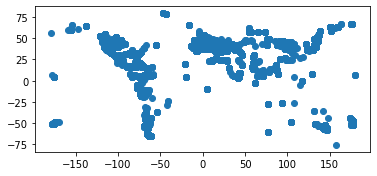

In [111]:
gpd_pbdb.plot()

`geopandas` makes it easy to save our data out as a shapefile

In [112]:
gpd_pbdb.to_file('reconstructed_pbdb_data_%sMa.shp' % reconstruction_time)

/Users/nickywright/miniconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/fm/9nwmq_gd47172_f70p3gk8nr0000gr/T/ipykernel_37701/1385639723.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd_pbdb.to_file('reconstructed_pbdb_data_%sMa.shp' % reconstruction_time)


### Reconstruct coastlines

In [89]:
reconstructed_coastlines = []
pygplates.reconstruct(coastlines, rotation_model, reconstructed_coastlines, reconstruction_time, export_wrap_to_dateline=True) 

### Plot

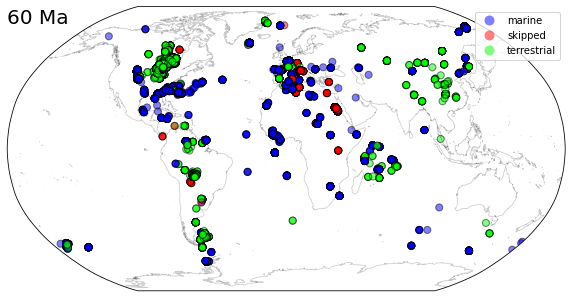

In [133]:
# --- define colours
markersize = 50
markeredgewidth = 1.5
alpha = 0.5

# plot map
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

# present-day coastlines
ax.coastlines(color='black', linewidth=0.75, resolution='50m', alpha=0.2)

# plot reconstructed coastlines
coastlines_for_plotting = []
date_line_wrapper = pygplates.DateLineWrapper()
for polygon in reconstructed_coastlines:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        coastlines_for_plotting.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))
ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='grey', alpha=0.25) 

# ---
# plot points
gpd_pbdb.plot(ax=ax, column='environment_broad', cmap='brg', alpha=alpha, edgecolor='k', 
                   markersize=markersize, transform=ccrs.PlateCarree(), legend=True)


plt.title('%s Ma' % reconstruction_time, fontsize=20, loc='left', y=0.92)
plt.show()


## Plot reconstructed fossils through time on multiple subplots

In [143]:
def reconstruct_and_plot(reconstruction_time, ax):
    
    # reconstruct fossils and coastlines
    reconstruction_time = reconstruction_time

    # reconstruct pbdb data
    reconstructed_pbdb = []
    pygplates.reconstruct(pbdb_cc, rotation_model, reconstructed_pbdb, reconstruction_time)

    gpd_pbdb = create_geodataframe_from_pbdb(reconstructed_pbdb, reconstruction_time)

    reconstructed_coastlines = []
    pygplates.reconstruct(coastlines, rotation_model, reconstructed_coastlines, reconstruction_time, export_wrap_to_dateline=True)
    
    # plot present-day coastlines
    ax.coastlines(color='black', linewidth=0.75, resolution='50m', alpha=0.2)

    # plot reconstructed coastlines
    coastlines_for_plotting = []
    date_line_wrapper = pygplates.DateLineWrapper()
    for polygon in reconstructed_coastlines:
        wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
        for poly in wrapped_polygons:
            coastlines_for_plotting.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))
    ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='grey', alpha=0.25) 

    # plot pbdb points
    gpd_pbdb.plot(ax=ax, column='environment_broad', cmap='brg', alpha=alpha, edgecolor='k', 
                   markersize=markersize, transform=ccrs.PlateCarree())
    
    ax.set_title('%s Ma' % reconstruction_time, fontsize=18, loc='left', y=0.92)


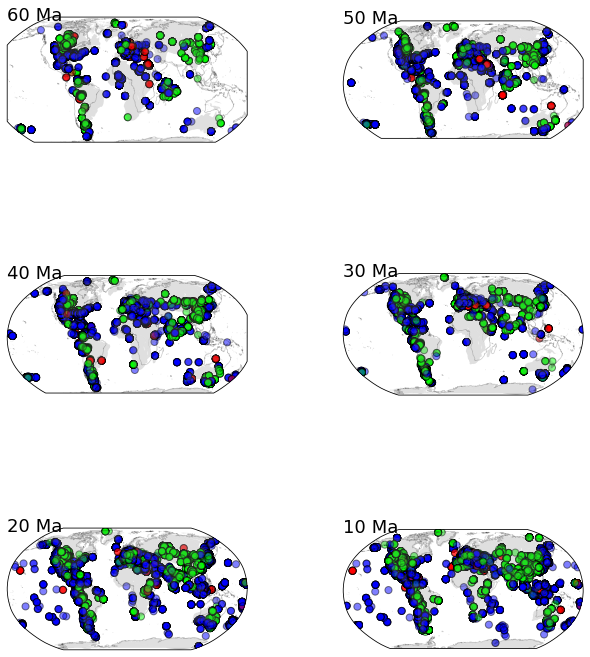

In [148]:
nrows = 3
ncols = 2

fig = plt.figure(figsize=(10, 12))

# --- first subplot
ax1 = plt.subplot(nrows, ncols, 1, projection=ccrs.Robinson())
reconstruct_and_plot(60, ax1)

# --- second subplot
ax2 = plt.subplot(nrows, ncols, 2, projection=ccrs.Robinson())
reconstruct_and_plot(50, ax2)

# --- third subplot
ax3 = plt.subplot(nrows, ncols, 3, projection=ccrs.Robinson())
reconstruct_and_plot(40, ax3)

# ---
ax4 = plt.subplot(nrows, ncols, 4, projection=ccrs.Robinson())
reconstruct_and_plot(30, ax4)

# ---
ax5 = plt.subplot(nrows, ncols, 5, projection=ccrs.Robinson())
reconstruct_and_plot(20, ax5)

# ---
ax6 = plt.subplot(nrows, ncols, 6, projection=ccrs.Robinson())
reconstruct_and_plot(10, ax6)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()